<a href="https://colab.research.google.com/github/CodingDuckmx/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/Jesus_CaballeroMedrano_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [X] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    # !pip install category_encoders==2.*
    # !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [0]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

#Instalation libraries section

In [0]:
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

#My work

In [0]:
#Split train  into train & val.

train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
### Baselines for classification.

train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
# We need a function to compare the columns for equal values.

for j in range(1,len(train.columns)):
  for i in range(j+1,len(train.columns)):
    if pd.DataFrame((train[train.columns[j]] == train[train.columns[i]]).value_counts(normalize=True)).index[0] == True:
      print('The columns', i ,'and', j,' have more equal values than non-equal.')
      # print((train[train.columns[1]] == train[train.columns[i]]).value_counts(normalize=True))
  


The columns 9 and 1  have more equal values than non-equal.
The columns 22 and 18  have more equal values than non-equal.
The columns 25 and 24  have more equal values than non-equal.
The columns 26 and 24  have more equal values than non-equal.
The columns 26 and 25  have more equal values than non-equal.
The columns 30 and 29  have more equal values than non-equal.
The columns 34 and 33  have more equal values than non-equal.
The columns 36 and 35  have more equal values than non-equal.
The columns 39 and 38  have more equal values than non-equal.


In [0]:
(train.isnull().sum()) / len(train) * 100

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.111111
gps_height                0.000000
installer                 6.138468
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.601852
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.563973
recorded_by               0.000000
scheme_management         6.582492
scheme_name              47.415825
permit                    5.140993
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [0]:
# Dropping columns


print("I'll be dropping the columns:", train.columns[[9,21,22,25,26,30,34,36,39 ]].tolist())
print(' ')
features = train.columns.drop(train.columns[[0,9,21,22,25,26,30,34,36,39,40]].tolist())

features


I'll be dropping the columns: ['num_private', 'scheme_name', 'permit', 'extraction_type_group', 'extraction_type_class', 'payment_type', 'quantity_group', 'source_type', 'waterpoint_type_group']
 


Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [0]:
train[features].describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000
mean,321.925261,669.567656,34.082431,-5.705946e+00,15.258291,5.616751,179.805513,1302.768939
std,3197.240487,693.005745,6.552053,2.941332e+00,17.530228,9.621230,463.081564,950.955437
min,0.000000,-63.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.092142,-8.528215e+00,5.000000,2.000000,0.000000,0.000000
50%,0.000000,372.500000,34.910740,-5.021436e+00,12.000000,3.000000,25.000000,1986.000000
75%,25.000000,1320.000000,37.170578,-3.327185e+00,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.344301,-2.000000e-08,99.000000,80.000000,15300.000000,2013.000000


In [0]:
display(train[features].describe(exclude='number'))

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,extraction_type,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type
count,47520,44616,44603,47520,47520,47234,47520,47520,47520,44876,47520,44392,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520
unique,349,1716,1929,30661,9,17231,21,124,2082,2,1,12,18,12,5,7,8,6,5,10,3,7
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,gravity,vwc,user-group,never pay,soft,good,enough,spring,groundwater,communal standpipe
freq,474,7321,13978,2879,8137,420,4250,2003,257,40838,47520,29470,21448,32449,42027,20287,40598,40598,26567,13620,36638,22778


In [0]:

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude','construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    
    # return the wrangled dataframe
    return X



In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
train[features].describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,46078.000000,46078.000000,47520.000000,47520.000000,47520.000000,31003.000000
mean,321.925261,669.567656,35.149033,-5.884512,15.258291,5.616751,179.805513,1996.825469
std,3197.240487,693.005745,2.604241,2.805599,17.530228,9.621230,463.081564,12.499247
min,0.000000,-63.000000,29.607122,-11.649440,1.000000,0.000000,0.000000,1960.000000
25%,0.000000,0.000000,33.284679,-8.633876,5.000000,2.000000,0.000000,1988.000000
50%,0.000000,372.500000,35.008578,-5.170151,12.000000,3.000000,25.000000,2000.000000
75%,25.000000,1320.000000,37.223501,-3.375068,17.000000,5.000000,215.000000,2008.000000
max,350000.000000,2770.000000,40.344301,-0.998464,99.000000,80.000000,15300.000000,2013.000000


In [0]:
### Select Features

target = 'status_group'

## get the dataframe with the columns to process
train_features = train[features]

#Get a list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#Get a series with the cardinality of nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

#Get a list of all categorical features with cardinality <=50
categorical_features = cardinality[cardinality <= 50].index.tolist()

#Combine lists

features2 =  numeric_features + categorical_features
print(len(features2))
features


23


Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [0]:
##Arange data into X features matrix and y target vector

X_train = train[features2]
y_train = train[target]
X_val = val[features2]
y_val = val[target]
X_test = test[features2]

In [252]:
### Use of scikit-learn pipelines

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(multi_class='auto',solver='lbfgs', n_jobs=1, max_iter=200)
)

#fit on train

pipeline.fit(X_train,y_train)

#Score on Val

print(f'Validation Accuracy by logistic regression {pipeline.score(X_val,y_val)}')

#predict on test

y_pred = pipeline.predict(X_test)

Validation Accuracy by logistic regression 0.7372053872053872


In [259]:
### Now by DecisionTree Classifier

for i in range(1,31,1):

  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(strategy='mean'),
      StandardScaler(),
      DecisionTreeClassifier(min_samples_leaf=i, random_state=42)
      )

  #Fit on train

  pipeline.fit(X_train,y_train)

  #Score on train and val
  print(f'Data for Sample leafs: {i}')
  print(f'Validation train Accuracy {pipeline.score(X_train,y_train)}')
  print(f'Validation Val Accuracy {pipeline.score(X_val,y_val)}')

  #predict on test

  y_pred = pipeline.predict(X_test)



Validation train Accuracy 0.9954755892255892
Validation Val Accuracy 0.7582491582491583
Validation train Accuracy 0.9335858585858586
Validation Val Accuracy 0.7592592592592593
Validation train Accuracy 0.9100799663299664
Validation Val Accuracy 0.762962962962963
Validation train Accuracy 0.8892255892255893
Validation Val Accuracy 0.7677609427609428
Validation train Accuracy 0.8763047138047138
Validation Val Accuracy 0.7696969696969697
Validation train Accuracy 0.8647306397306397
Validation Val Accuracy 0.7707912457912458
Validation train Accuracy 0.8562710437710438
Validation Val Accuracy 0.7728956228956229
Validation train Accuracy 0.8486952861952862
Validation Val Accuracy 0.7707070707070707
Validation train Accuracy 0.8428240740740741
Validation Val Accuracy 0.7718855218855218
Validation train Accuracy 0.8376262626262626
Validation Val Accuracy 0.7715488215488215
Validation train Accuracy 0.8333543771043771
Validation Val Accuracy 0.7758417508417509
Validation train Accuracy 0.82899

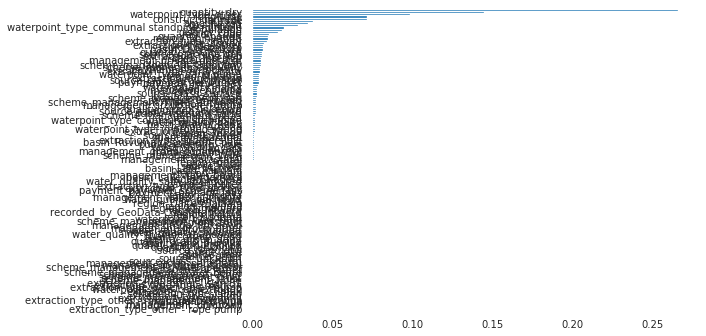

In [264]:
### Features importances

model = pipeline.named_steps['decisiontreeclassifier']

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_,encoded_columns)

importances.sort_values().plot.barh();

#Draft

In [0]:
(train[train['latitude'] == -2e-08]['latitude']).sort_values()

32604   -2.000000e-08
15833   -2.000000e-08
50379   -2.000000e-08
36069   -2.000000e-08
839     -2.000000e-08
             ...     
10250   -2.000000e-08
57666   -2.000000e-08
6920    -2.000000e-08
25291   -2.000000e-08
11992   -2.000000e-08
Name: latitude, Length: 1442, dtype: float64

In [0]:
(train[train.columns[33]] == train[train.columns[34]]).value_counts()

pd.DataFrame((train[train.columns[1]] == train[train.columns[9]]).value_counts(normalize=True)).index[0] == False
# train[train.columns[34]]

pd.DataFrame((train[train.columns[20]] == train[train.columns[21]]).value_counts(normalize=True))

# train[train.columns[25]]
# train.columns[20]

,0
False,1.0


In [0]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [0]:
train.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
